In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn import svm
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from tpot import TPOTClassifier
from sklearn.ensemble import ExtraTreesClassifier
import itertools
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn import metrics
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier

In [2]:
model_data = pd.read_pickle('clean_added_data.pkl')

In [3]:
model_data.columns.tolist()

['rate_avg',
 'prescriptions_per_100',
 'uninsured_2015',
 'uninsured_2016',
 'uninsured_2017',
 'population_estimate',
 'median age',
 'Employment/Population Ratio; Estimate; AGE - 16 to 19 years',
 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years',
 'Employment/Population Ratio; Estimate; AGE - 25 to 29 years',
 'Employment/Population Ratio; Estimate; AGE - 30 to 34 years',
 'Employment/Population Ratio; Estimate; AGE - 35 to 44 years',
 'Employment/Population Ratio; Estimate; AGE - 45 to 54 years',
 'Employment/Population Ratio; Estimate; AGE - 55 to 59 years',
 'Employment/Population Ratio; Estimate; AGE - 60 to 64 years',
 'Employment/Population Ratio; Estimate; AGE - 65 to 74 years',
 'Employment/Population Ratio; Estimate; AGE - 75 years and over',
 'Percent households receiving food stamps/SNAP; Estimate; Households',
 'percent_in_labor_force',
 'percent_in_civilian_labor_force',
 'percent_in_civilian_labor_force_employed',
 'percent_in_civilian_labor_force_unemploy

In [4]:
model_data = model_data.drop(['for_merge'], axis=1)

In [5]:
#additional feature engineering 
model_data['yoy_change_uninsured'] = model_data['uninsured_2016'] - model_data['uninsured_2015'] / model_data['uninsured_2015']

model_data['prop Under 30'] = model_data['Under 30'] / model_data['population_estimate']
model_data['prop 30 to 44'] = model_data['30 to 44'] / model_data['population_estimate']
model_data['prop 45 to 64'] = model_data['45 to 64'] / model_data['population_estimate']
model_data['prop 65 and over'] = model_data['65 and over'] / model_data['population_estimate']

model_data = model_data.drop(['uninsured_2017', 'prop Under 30', 'population_estimate', '30 to 44','45 to 64', '65 and over', 'pop_white','pop_black', 'pop_native_american','pop_asian', 'pop_pac_islander','pop_ohter race','pop_two_more_races', 'county_state'], axis=1)


In [6]:
model_data.shape

(2517, 58)

In [7]:
#verify no nulls before running models 
model_data.isna().sum()

rate_avg                                                               0
prescriptions_per_100                                                  0
uninsured_2015                                                         0
uninsured_2016                                                         0
median age                                                             0
Employment/Population Ratio; Estimate; AGE - 16 to 19 years            0
Employment/Population Ratio; Estimate; AGE - 20 to 24 years            0
Employment/Population Ratio; Estimate; AGE - 25 to 29 years            0
Employment/Population Ratio; Estimate; AGE - 30 to 34 years            0
Employment/Population Ratio; Estimate; AGE - 35 to 44 years            0
Employment/Population Ratio; Estimate; AGE - 45 to 54 years            0
Employment/Population Ratio; Estimate; AGE - 55 to 59 years            0
Employment/Population Ratio; Estimate; AGE - 60 to 64 years            0
Employment/Population Ratio; Estimate; AGE - 65 to 

In [8]:
model_data.head()

,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,median age,Employment/Population Ratio; Estimate; AGE - 16 to 19 years,Employment/Population Ratio; Estimate; AGE - 20 to 24 years,Employment/Population Ratio; Estimate; AGE - 25 to 29 years,Employment/Population Ratio; Estimate; AGE - 30 to 34 years,Employment/Population Ratio; Estimate; AGE - 35 to 44 years,...,longitude_y,prop_white,prop_black,prop_native_american,pop_other_race,prop_congregations_pop,prop_adherents_pop,prop 30 to 44,prop 45 to 64,prop 65 and over
0,0,129.6,0.128,0.134,37.8,21.7,71.2,77.6,74.7,70.8,...,-86.902298,0.768606,0.185217,0.004105,0.013879,0.001326,0.445149,0.000356,0.000480,0.000269
1,1,123.8,0.158,0.175,42.3,33.9,71.7,69.7,71.8,79.7,...,-86.902298,0.864323,0.093198,0.006792,0.008852,0.001007,0.332495,0.000091,0.000139,0.000098
2,0,92.7,0.175,0.174,38.7,14.6,46.7,45.7,47.9,52.8,...,-86.902298,0.467047,0.479297,0.001728,0.041294,0.002480,0.449200,0.000725,0.000996,0.000654
3,1,97.2,0.151,0.150,40.2,12.9,42.7,48.6,58.7,56.1,...,-86.902298,0.769537,0.212121,0.003589,0.000354,0.002968,0.427787,0.000895,0.001223,0.000700
4,1,56.9,0.183,0.176,40.8,19.0,53.3,64.8,58.2,70.8,...,-86.902298,0.954405,0.015683,0.003483,0.008682,0.002392,0.449120,0.000322,0.000468,0.000310


In [58]:
model_data.columns.tolist()

['rate_avg',
 'prescriptions_per_100',
 'uninsured_2015',
 'uninsured_2016',
 'median age',
 'Employment/Population Ratio; Estimate; AGE - 16 to 19 years',
 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years',
 'Employment/Population Ratio; Estimate; AGE - 25 to 29 years',
 'Employment/Population Ratio; Estimate; AGE - 30 to 34 years',
 'Employment/Population Ratio; Estimate; AGE - 35 to 44 years',
 'Employment/Population Ratio; Estimate; AGE - 45 to 54 years',
 'Employment/Population Ratio; Estimate; AGE - 55 to 59 years',
 'Employment/Population Ratio; Estimate; AGE - 60 to 64 years',
 'Employment/Population Ratio; Estimate; AGE - 65 to 74 years',
 'Employment/Population Ratio; Estimate; AGE - 75 years and over',
 'Percent households receiving food stamps/SNAP; Estimate; Households',
 'percent_in_labor_force',
 'percent_in_civilian_labor_force',
 'percent_in_civilian_labor_force_employed',
 'percent_in_civilian_labor_force_unemployed',
 'percent_in_labor_force_armed_forces'

Text(0.5, 1.0, 'Age-Adjusted Death Rate Class Balance')

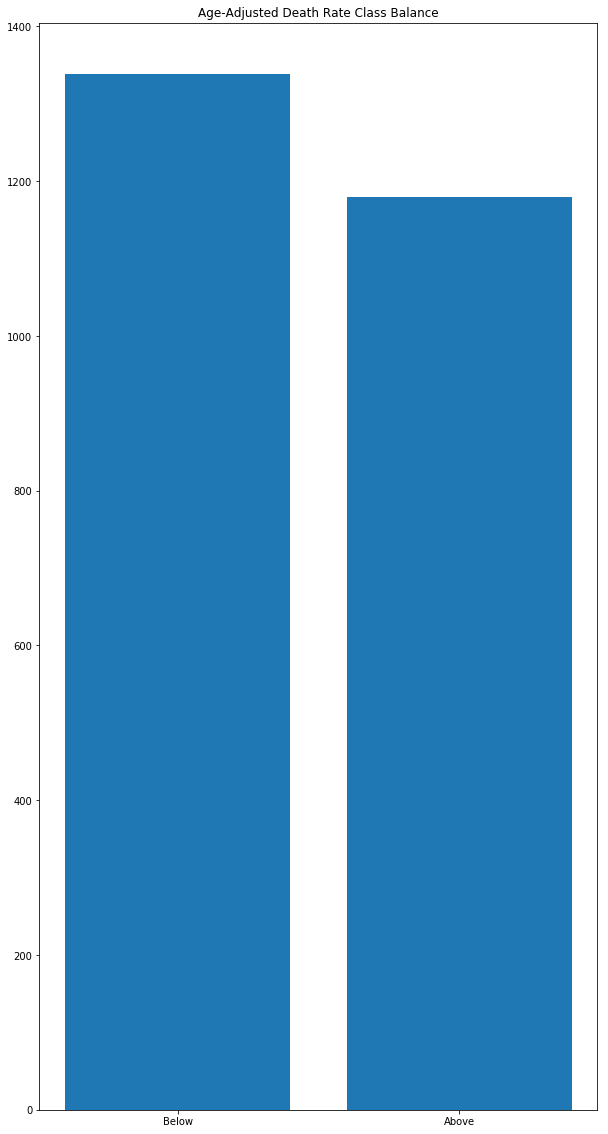

In [9]:
#investigate class imbalance 
model_data['rate_avg'].value_counts().tolist()
col_name = ['Below', 'Above']

plt.figure(figsize=(10,20))
plt.bar(col_name, model_data['rate_avg'].value_counts().tolist())
plt.title('Age-Adjusted Death Rate Class Balance')

In [10]:
#split into X and y and scale X 
X = model_data.drop(['rate_avg'], axis=1)
y = model_data.rate_avg

#add dummy variables
X = pd.get_dummies(X)

#scale features with MinMaxScalers
cols = X.columns.tolist()
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Testing Models

###### Model Functions

In [72]:
def log_reg(X_train, X_test, y_train, y_test): 
    logreg = LogisticRegression(fit_intercept = False, C = 1e12) 

    model_log = logreg.fit(X_train, y_train)
    model_log
    y_hat_test = logreg.predict(X_test)
    y_hat_train = logreg.predict(X_train)
    residuals = y_train - y_hat_train
    print(pd.Series(residuals).value_counts())
    print(pd.Series(residuals).value_counts(normalize=True))

    residuals = y_test - y_hat_test
    print(pd.Series(residuals).value_counts())
    print(pd.Series(residuals).value_counts(normalize=True))
    print(print_metrics(y_test, y_pred))
    coefs = logreg.coef_
    return coefs

In [14]:
def rf_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 123))])

    # Set grid search params
    param_grid_forest = [ 
      {'clf__n_estimators': [100, 120],
       'clf__criterion': ['entropy', 'gini'], 
       'clf__max_depth': [4, 5, 6],  
       'clf__min_samples_leaf':[0.05 ,0.1, 0.2, 1, 2],  
       'clf__min_samples_split':[0.05 ,0.1, 0.2, 1.0, 2]
      }
    ]

    # Construct grid search
    gs_rf = GridSearchCV(estimator=pipe_rf,
                param_grid=param_grid_forest,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_rf.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_rf.best_score_)

    # Best params
    print('\nBest params:\n', gs_rf.best_params_)

In [71]:
def knn_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

    # Set grid search params
    knn_param_grid = {
        'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]
    }


    # Construct grid search
    gs_knn = GridSearchCV(estimator=pipe_knn,
                param_grid=knn_param_grid,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_knn.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_knn.best_score_)

    # Best params
    print('\nBest params:\n', gs_knn.best_params_)
    print(print_metrics(y_test, y_pred))

In [70]:
def svm_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_svm = Pipeline([('clf', svm.SVC(random_state=123))])

    # Set grid search params
    param_grid_svm = [
    #  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
      {'clf__C': [0.1, 1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf', 'linear']},
     ]

    # Construct grid search
    gs_svm = GridSearchCV(estimator=pipe_svm,
                param_grid=param_grid_svm,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_svm.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_svm.best_score_)

    # Best params
    print('\nBest params:\n', gs_svm.best_params_)
    print(print_metrics(y_test, y_pred))

In [17]:
def adaboost_gs(X_train, X_test, y_train, y_test):
    adaboost_clf = AdaBoostClassifier()

    adaboost_clf.fit(X_train, y_train)
    adaboost_train_preds = adaboost_clf.predict(X_train)
    adaboost_test_preds = adaboost_clf.predict(X_test)

    adaboost_train_score = accuracy_score(y_train, adaboost_train_preds)
    adaboost_test_score = accuracy_score(y_test, adaboost_test_preds)

    print('AdaBoosting')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(adaboost_train_score, adaboost_test_score))
    print("F1 Score: {}".format(f1_score(y_test, adaboost_test_preds, average='micro')))

In [18]:
def gb_gs(X_train, X_test, y_train, y_test):
    gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)

    gb_clf.fit(X_train, y_train)
    gb_train_preds = gb_clf.predict(X_train)
    gb_test_preds = gb_clf.predict(X_test)

    gb_train_score = accuracy_score(y_train, gb_train_preds)
    gb_test_score = accuracy_score(y_test, gb_test_preds)

    print('Gradient Boosting')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(gb_train_score, gb_test_score))
    print("F1 Score: {}".format(f1_score(y_test, gb_test_preds, average='micro')))

In [19]:
#function to show model metrics
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [20]:
#function to display confusion matrix 
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

In [22]:
#drop colinear features as prerequisite for logistic regression 
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix (so as not to include self-correlations of 1)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# features_selected_train.drop(columns=to_drop, inplace=True)

In [23]:
to_drop

['uninsured_2016',
 'percent_in_civilian_labor_force',
 'percent_in_civilian_labor_force_employed',
 'percent_not_in_labor_force',
 'Under 30',
 'yoy_change_uninsured',
 'Density per square mile of land area - Housing units',
 'prop 30 to 44',
 'prop 45 to 64',
 'Medicinal_Yes']

In [24]:
X = X.drop(to_drop, axis=1)

In [26]:
#separate data into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
X_train.head()

,prescriptions_per_100,uninsured_2015,median age,Employment/Population Ratio; Estimate; AGE - 16 to 19 years,Employment/Population Ratio; Estimate; AGE - 20 to 24 years,Employment/Population Ratio; Estimate; AGE - 25 to 29 years,Employment/Population Ratio; Estimate; AGE - 30 to 34 years,Employment/Population Ratio; Estimate; AGE - 35 to 44 years,Employment/Population Ratio; Estimate; AGE - 45 to 54 years,Employment/Population Ratio; Estimate; AGE - 55 to 59 years,...,prop_black,prop_native_american,pop_other_race,prop_congregations_pop,prop_adherents_pop,prop 65 and over,Medicinal_No,Decriminalized_No,Decriminalized_Reduced,Decriminalized_Yes
458,0.352544,0.551821,0.275058,0.229,0.396,0.747412,0.724790,0.784293,0.642755,0.480795,...,0.525188,0.000956,0.087979,0.049777,0.015360,0.002665,1.0,1.0,0.0,0.0
503,0.013911,0.498599,0.377622,0.133,0.277,0.296066,0.461134,0.391623,0.317073,0.381457,...,0.415194,0.002633,0.017937,0.204438,0.042861,0.009538,1.0,1.0,0.0,0.0
820,0.073132,0.229692,0.531469,0.478,0.772,0.924431,0.864496,0.818848,0.895265,0.792053,...,0.006938,0.000000,0.009950,0.191867,0.078347,0.011433,1.0,1.0,0.0,0.0
2056,0.041733,0.591036,0.331002,0.258,0.357,0.673913,0.608193,0.590576,0.520803,0.402649,...,0.014920,0.008332,0.237696,0.075372,0.067056,0.008304,1.0,1.0,0.0,0.0
1473,0.481320,0.498599,0.438228,0.234,0.647,0.706004,0.702731,0.636649,0.516499,0.529801,...,0.007261,0.001909,0.008671,0.209678,0.047934,0.005283,0.0,0.0,1.0,0.0


###### Logistic Regression

In [73]:
x = log_reg(X_train, X_test, y_train, y_test)

 0    1437
 1     240
-1     210
Name: rate_avg, dtype: int64
 0    0.761526
 1    0.127186
-1    0.111288
Name: rate_avg, dtype: float64
 0    486
 1     88
-1     56
Name: rate_avg, dtype: int64
 0    0.771429
 1    0.139683
-1    0.088889
Name: rate_avg, dtype: float64
Precision Score: 0.7886792452830189
Recall Score: 0.6785714285714286
Accuracy Score: 0.753968253968254
F1 Score: 0.7294938917975567
None


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
coef_values = x.tolist()[0]
coef_values 

[1.2724018410262057,
 1.250249332216141,
 2.1390636766798425,
 0.050376111323663306,
 -0.6833938551820368,
 -1.705816118131333,
 0.4327967570473373,
 -0.9458826675938435,
 -2.8619023064052564,
 -2.239929443613641,
 -0.8169192042499713,
 -0.030896114795860238,
 -0.36738735660372607,
 -1.392329223334058,
 1.7301336682969728,
 2.370160310727572,
 -2.5995940428369004,
 15.356473567296202,
 -2.2259843426775965,
 0.5394500229321554,
 2.880184097120504,
 -1.1312734058160736,
 -2.3792722796487573,
 1.340102056781648,
 -0.9956819567054738,
 -1.1138172343712913,
 1.3179771219223817,
 -0.2117387378241349,
 -2.191045043272264,
 3.372204362970227,
 0.7115833823074902,
 0.8811762636480577,
 0.14966094552591888,
 -4.9774585328342145,
 0.577399151636836,
 16.402934414082157,
 7.858236172789335,
 -0.9579420816563269,
 -1.1546856796061382,
 2.6907051630569914,
 -3.810775510495301,
 3.0615843448921987,
 -0.8135322378319599,
 -0.24619944978789102,
 1.5267018880015863,
 -7.801979136690007,
 -0.538436491404

In [30]:
columns = X_train.columns.tolist()
columns

['prescriptions_per_100',
 'uninsured_2015',
 'median age',
 'Employment/Population Ratio; Estimate; AGE - 16 to 19 years',
 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years',
 'Employment/Population Ratio; Estimate; AGE - 25 to 29 years',
 'Employment/Population Ratio; Estimate; AGE - 30 to 34 years',
 'Employment/Population Ratio; Estimate; AGE - 35 to 44 years',
 'Employment/Population Ratio; Estimate; AGE - 45 to 54 years',
 'Employment/Population Ratio; Estimate; AGE - 55 to 59 years',
 'Employment/Population Ratio; Estimate; AGE - 60 to 64 years',
 'Employment/Population Ratio; Estimate; AGE - 65 to 74 years',
 'Employment/Population Ratio; Estimate; AGE - 75 years and over',
 'Percent households receiving food stamps/SNAP; Estimate; Households',
 'percent_in_labor_force',
 'percent_in_civilian_labor_force_unemployed',
 'percent_in_labor_force_armed_forces',
 'percent_income_below_poverty_line',
 'Total Health Spending',
 'SMHA Expenditures Per Capita',
 'share_medica

In [31]:
coef_dict = {}
for i in range(len(columns)):
    coef_dict[columns[i]] = coef_values[i]
    
coef_dict = sorted(coef_dict.items(), key=lambda x: x[1])

In [33]:
coef_dict

[('prop 65 and over', -7.801979136690007),
 ('renter_to_total_hh', -4.9774585328342145),
 ('prop_black', -3.810775510495301),
 ('Employment/Population Ratio; Estimate; AGE - 45 to 54 years',
  -2.8619023064052564),
 ('percent_in_labor_force_armed_forces', -2.5995940428369004),
 ('share_student_loan_debt', -2.3792722796487573),
 ('Employment/Population Ratio; Estimate; AGE - 55 to 59 years',
  -2.239929443613641),
 ('Total Health Spending', -2.2259843426775965),
 ('pot_dangerous_industries', -2.191045043272264),
 ('Employment/Population Ratio; Estimate; AGE - 25 to 29 years',
  -1.705816118131333),
 ('Percent households receiving food stamps/SNAP; Estimate; Households',
  -1.392329223334058),
 ('longitude_y', -1.1546856796061382),
 ('median_medical_debt_collections', -1.1312734058160736),
 ('auto_retail_debt_delinquency_rate', -1.1138172343712913),
 ('share_with_auto_or_retail_debt', -0.9956819567054738),
 ('latitude_y', -0.9579420816563269),
 ('Employment/Population Ratio; Estimate; AG

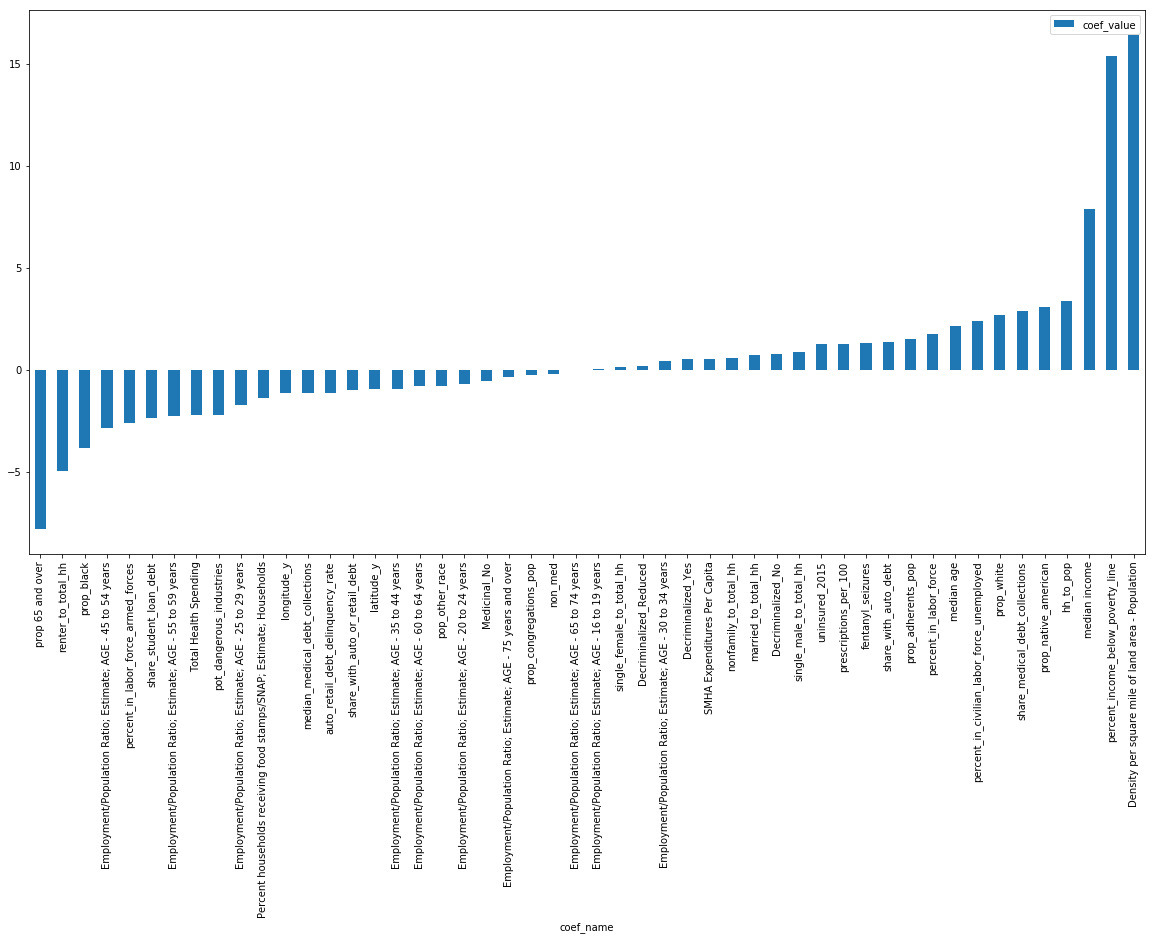

In [34]:
#visualize feature importance
df = pd.DataFrame(coef_dict, columns=['coef_name', 'coef_value'])
df.plot(kind='bar', x='coef_name', figsize=(20,10))

[Text(0, 0, 'Prop of Pop 65+'),
 Text(0, 0, 'Ratio Renter to Total HH'),
 Text(0, 0, 'Prop of Pop Black'),
 Text(0, 0, 'Emp to Pop 45-54 Ratio'),
 Text(0, 0, '% in Labor Force - Armed Forces'),
 Text(0, 0, 'Share Student Loan Debt'),
 Text(0, 0, 'Emp to Pop 55-59 Ratio'),
 Text(0, 0, 'Total Health Spending'),
 Text(0, 0, 'Prop Pop Potentially Industries'),
 Text(0, 0, 'Median Age'),
 Text(0, 0, '% Unemployed Civilian Labor Force'),
 Text(0, 0, 'Prop of Pop White'),
 Text(0, 0, 'Share Medical Debt Collections'),
 Text(0, 0, 'Prop of Pop Native American'),
 Text(0, 0, 'Number of HH Per Pop'),
 Text(0, 0, 'Median Income'),
 Text(0, 0, '% Pop Income Below Poverty Line'),
 Text(0, 0, 'Pop Density Per Square Mile')]

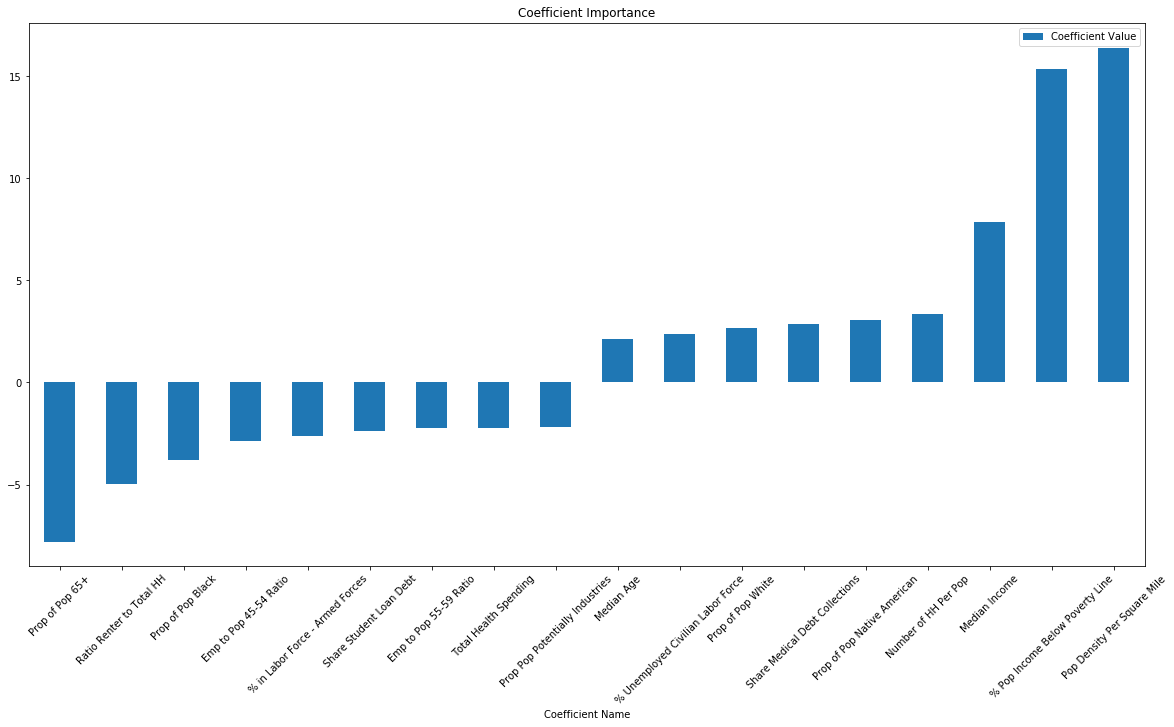

In [35]:
#visualize feature importance for most important features - absolute value >2
df = pd.DataFrame(coef_dict, columns=['Coefficient Name', 'Coefficient Value'])
df = df.loc[df['Coefficient Value'].abs() > 2]
ax = df.plot(kind='bar', x='Coefficient Name', figsize=(20,10), title='Coefficient Importance')
ax.set_xticklabels(['Prop of Pop 65+', 'Ratio Renter to Total HH', 'Prop of Pop Black', 'Emp to Pop 45-54 Ratio', '% in Labor Force - Armed Forces', 'Share Student Loan Debt', 'Emp to Pop 55-59 Ratio', 'Total Health Spending', 'Prop Pop Potentially Industries', 'Median Age', '% Unemployed Civilian Labor Force', 'Prop of Pop White', 'Share Medical Debt Collections', 'Prop of Pop Native American', 'Number of HH Per Pop', 'Median Income', '% Pop Income Below Poverty Line', 'Pop Density Per Square Mile'], rotation=45)

[Text(0, 0, 'Prop of Pop 65+'),
 Text(0, 0, 'Ratio Renter to Total HH'),
 Text(0, 0, 'Prop of Pop Black'),
 Text(0, 0, 'Prop of Pop Native American'),
 Text(0, 0, 'Number of HH Per Pop'),
 Text(0, 0, 'Median Income'),
 Text(0, 0, '% of Pop Income Below Poverty Line'),
 Text(0, 0, 'Pop Density Per Square Mile')]

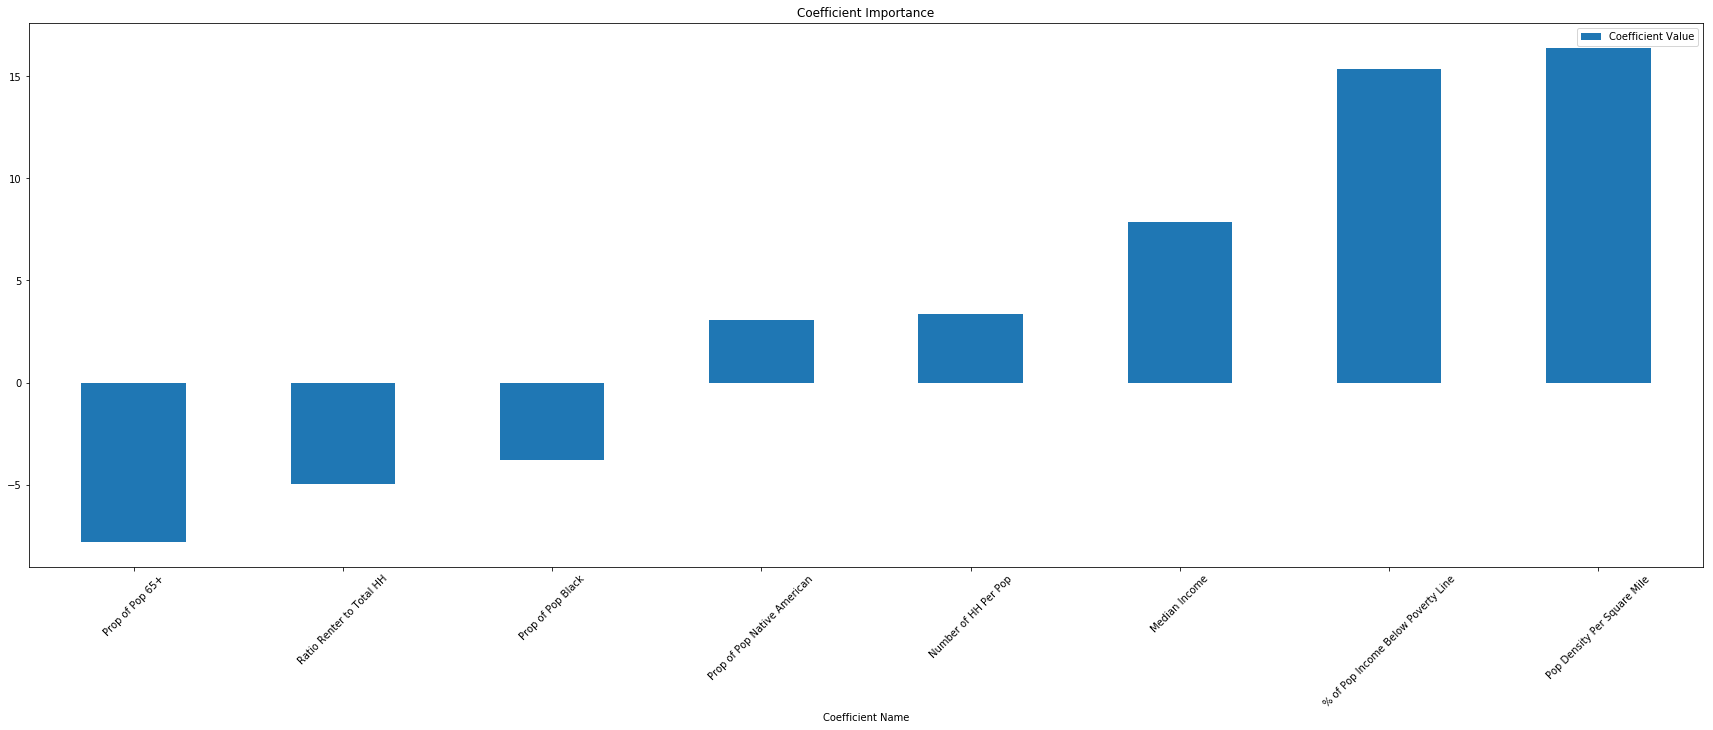

In [36]:
#visualize feature importance for most important features - absolute value >3
df = pd.DataFrame(coef_dict, columns=['Coefficient Name', 'Coefficient Value'])
df = df.loc[df['Coefficient Value'].abs() > 3]
ax = df.plot(kind='bar', x='Coefficient Name', figsize=(30,10), title='Coefficient Importance')
ax.set_xticklabels(['Prop of Pop 65+', 'Ratio Renter to Total HH', 'Prop of Pop Black', 'Prop of Pop Native American', 'Number of HH Per Pop', 'Median Income', '% of Pop Income Below Poverty Line', 'Pop Density Per Square Mile'], rotation=45)

###### Random Forest

In [59]:
rf_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__m

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_sp

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, 

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_sp

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimator

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  4.6min finished


Best accuracy: 0.752

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


###### K Nearest Neighbors

In [74]:
knn_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=4 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    4.0s finished


In [75]:
svm_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    7.7s finished


Best accuracy: 0.744

Best params:
 {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'linear'}
Precision Score: 0.7886792452830189
Recall Score: 0.6785714285714286
Accuracy Score: 0.753968253968254
F1 Score: 0.7294938917975567
None


In [62]:
adaboost_gs(X_train, X_test, y_train, y_test)

AdaBoosting
Training Accuracy: 0.8034 		 Testing Accuracy: 0.754
F1 Score: 0.753968253968254


In [63]:
gb_gs(X_train, X_test, y_train, y_test)

Gradient Boosting
Training Accuracy: 0.8368 		 Testing Accuracy: 0.7651
F1 Score: 0.765079365079365


In [65]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)
etc.score(X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.753968253968254

In [67]:
print_metrics(y_test, y_pred)

Precision Score: 0.7886792452830189
Recall Score: 0.6785714285714286
Accuracy Score: 0.753968253968254
F1 Score: 0.7294938917975567


In [720]:
# etc = ExtraTreesClassifier(RandomForestClassifier(bootstrap=True, criterion='entropy', max_features=0.15000000000000002, min_samples_leaf=8, min_samples_split=10, n_estimators=100), bootstrap=False, criterion='gini', max_features=0.7500000000000001, min_samples_leaf=16, min_samples_split=19, n_estimators=100)

rf = RandomForestClassifier(bootstrap=True, criterion='entropy', max_features=0.15000000000000002, min_samples_leaf=8, min_samples_split=10, n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)


0.773015873015873

In [44]:
rf2 = RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=0.05, min_samples_leaf=1, min_samples_split=8, n_estimators=100, random_state=615)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)
rf2.score(X_test, y_test)

0.7904761904761904

In [45]:
print_metrics(y_test, y_pred)

Precision Score: 0.8165467625899281
Recall Score: 0.737012987012987
Accuracy Score: 0.7904761904761904
F1 Score: 0.7747440273037542


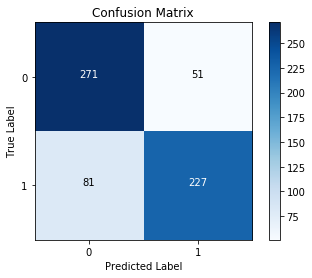

In [46]:
show_cf(y_test, y_pred)

In [47]:
!pip install pydotplus

In [53]:
!pip install pydot

In [49]:
estimator = rf2.estimators_

In [56]:
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in estimator:
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=X.columns,
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1

#### Use dummy classifier to create baseline model 

In [1159]:
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
y_pred = dummy_classifier.predict(X_test)
dummy_classifier.score(X_test, y_test)

0.5111111111111111

In [1158]:
print_metrics(y_test, y_pred)

Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.5111111111111111
F1 Score: 0.0


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


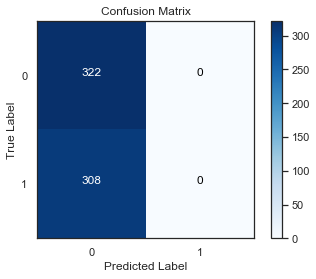

In [1161]:
show_cf(y_test, y_pred)

In [1146]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
dummy_classifier.predict(X_test)
dummy_classifier.score(X_test, y_test)

0.4793650793650794

In [1147]:
dummy_classifier = DummyClassifier(strategy='prior')
dummy_classifier.fit(X_train, y_train)
dummy_classifier.predict(X_test)
dummy_classifier.score(X_test, y_test)

0.5111111111111111

In [1148]:
dummy_classifier = DummyClassifier(strategy='uniform')
dummy_classifier.fit(X_train, y_train)
dummy_classifier.predict(X_test)
dummy_classifier.score(X_test, y_test)

0.49682539682539684

In [1167]:
((.79-.511)/.511)*100

54.59882583170255